In [5]:
import pytz
import plotly.express as px
import seaborn as sns
from datetime import datetime
from datetime import timezone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
import statsmodels
import logging
import warnings
from darts.datasets import AirPassengersDataset
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.metrics import mape, mase
from darts import TimeSeries
%matplotlib inline

# Calendar

In [6]:
calendar60 = pd.read_csv("../../RDN/Load Data (2018-2019)/artifacts/time_60min.csv", index_col=0)
calendar15 = pd.read_csv("../../RDN/Load Data (2018-2019)/artifacts/time_15min.csv", index_col=0)

In [8]:
calendar60.head(3)

,datetime,year,month,day,hour,minute,second,weekday,monthday,weekend,...,month_sin,weekday_sin,monthday_sin,yearday_sin,hour_sin,month_cos,weekday_cos,monthday_cos,yearday_cos,hour_cos
0,2018-01-01 00:00:00,2018,1,1,0,0,0,0,0,True,...,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,1.0,1.0,1.000000
1,2018-01-01 01:00:00,2018,1,1,1,0,0,0,0,True,...,0.0,0.0,0.0,0.0,0.258819,1.0,1.0,1.0,1.0,0.965926
2,2018-01-01 02:00:00,2018,1,1,2,0,0,0,0,True,...,0.0,0.0,0.0,0.0,0.500000,1.0,1.0,1.0,1.0,0.866025


c:\Ubuntu\Dev\Windows\I-NERGY\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


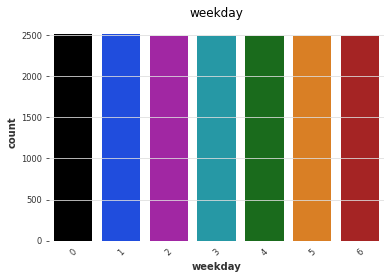

c:\Ubuntu\Dev\Windows\I-NERGY\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


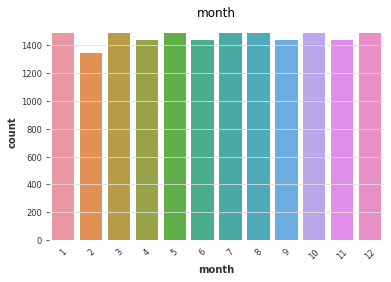

c:\Ubuntu\Dev\Windows\I-NERGY\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


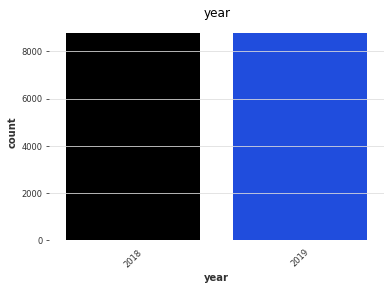

c:\Ubuntu\Dev\Windows\I-NERGY\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


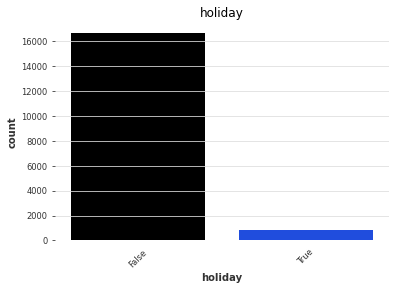

In [9]:
for col in ['weekday', 'month', 'year', 'holiday']:
    sns.countplot(calendar60[col])
    plt.title(col)
    plt.xticks(rotation=45)
    plt.show()


1. We have data for all the weekdays without almost equal counts which is expected.
2. Month data quantity is fluctuating according to fluctuation of number of days of each month (28, 30. 31)
3. The year distribution looks OK as we have equal data samples from 2018 and 2019.
4. Same thing for holidays.

# Timeseries (hourly)

In [10]:
ts60 = pd.read_csv("../../RDN/Load Data (2018-2019)/artifacts/load_60min.csv", index_col=0, parse_dates=True)
ts60_plus_time = pd.read_csv("../../RDN/Load Data (2018-2019)/artifacts/timeseries_plus_time_60min.csv", index_col=0)

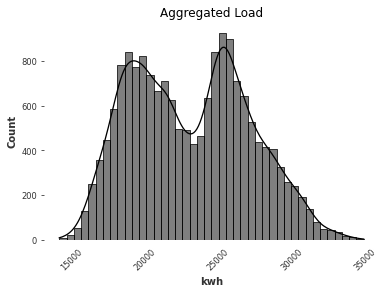

In [11]:
ax = sns.histplot(x=ts60['Load'], kde=True)
plt.xticks(rotation=45)
ax.set(xlabel='kwh', title='Aggregated Load')
plt.grid()

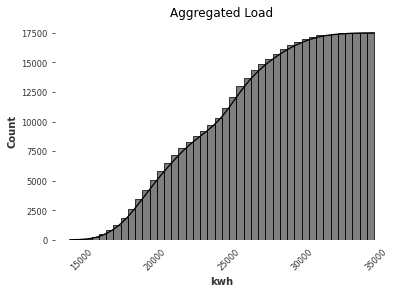

In [12]:
ax = sns.histplot(x=ts60['Load'], kde=True, cumulative=True)
plt.xticks(rotation=45)
ax.set(xlabel='kwh', title='Aggregated Load')
plt.grid()

In [13]:
fig = px.line(ts60, title='Aggregated Load (kwh)')
fig.show()

Load [kWh]:


<AxesSubplot:xlabel='weekend'>

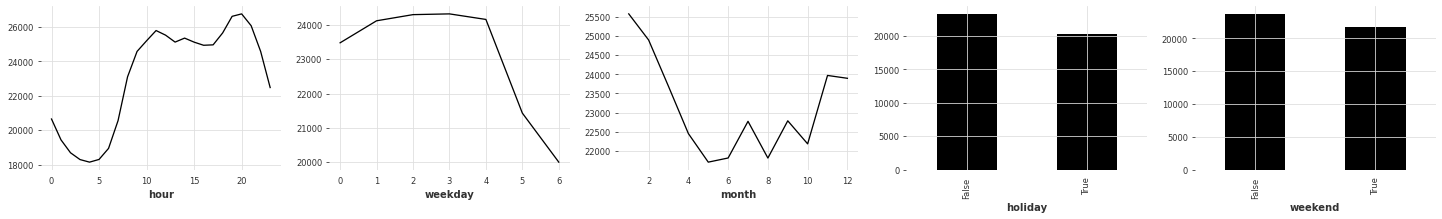

In [14]:
fig, axes = plt.subplots(1, 5)
print('Load [kWh]:')
ts60_plus_time.groupby('hour')['Load'].mean().plot(ax=axes[0], figsize=(25, 4))
ts60_plus_time.groupby('weekday')['Load'].mean().plot(ax=axes[1], figsize=(25, 3))
ts60_plus_time.groupby('month')['Load'].mean().plot(ax=axes[2], figsize=(25, 3))
ts60_plus_time.groupby('holiday')['Load'].mean().plot.bar(ax=axes[3], figsize=(25, 3))
ts60_plus_time.groupby('weekend')['Load'].mean().plot.bar(ax=axes[4], figsize=(25, 3))


**Observations: **
1. Load peaks are observed mainly during the afternoon until 21.00
2. Working days exhibit the highest of loads
3. The total loads are much higher during the winter monts. May and June have the lowest mean value (probably due to the abscence of both cooling and heating loads)
4. Holidays weekends and working days clearly lead to reduction of the mean values of the total load

# Initial Time Series Analysis - Darts and statsmodels
## ACF / PACF

In [27]:
series = TimeSeries.from_dataframe(ts60)
series

<TimeSeries (DataArray) (Date: 17520, component: 1, sample: 1)>
array([[[18555.875064]],

       [[18001.483151]],

       [[17017.792074]],

       ...,

       [[22831.923657]],

       [[21943.306233]],

       [[20979.633802]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2018-01-01 ... 2019-12-31T23:00:00
  * component  (component) object 'Load'
Dimensions without coordinates: sample

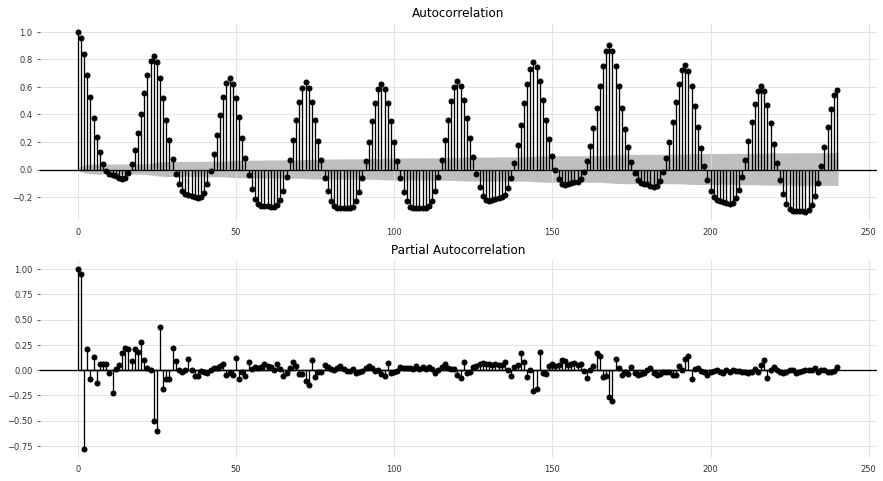

In [28]:
import statsmodels.api as sm
fig, ax = plt.subplots(2,1, figsize=(15, 8))
fig = sm.graphics.tsa.plot_acf(ts60['Load'], lags=24*10, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ts60['Load'], lags=24*10, ax=ax[1])
plt.show()


Both plots demonstrate the need for both daily and weekly AR (PACF) and MA (ACF) terms.

## Seasonality checks with darts

In [31]:
for m in range(2, 366*24):
    is_seasonal, period = check_seasonality(series, m=m, alpha=.05, max_lag=500*24)
    if is_seasonal:
        print('There is seasonality of order {}.'.format(period))

There is seasonality of order 24.
There is seasonality of order 48.
There is seasonality of order 72.
There is seasonality of order 96.
There is seasonality of order 120.
There is seasonality of order 144.
There is seasonality of order 168.
There is seasonality of order 192.
There is seasonality of order 216.
There is seasonality of order 240.
There is seasonality of order 264.
There is seasonality of order 288.
There is seasonality of order 312.
There is seasonality of order 336.
There is seasonality of order 360.
There is seasonality of order 384.
There is seasonality of order 408.
There is seasonality of order 432.
There is seasonality of order 456.
There is seasonality of order 480.
There is seasonality of order 504.
There is seasonality of order 528.
There is seasonality of order 552.
There is seasonality of order 576.
There is seasonality of order 600.
There is seasonality of order 624.
There is seasonality of order 648.
There is seasonality of order 672.
There is seasonality of 

### Example decomposition to capture daily seasonalities

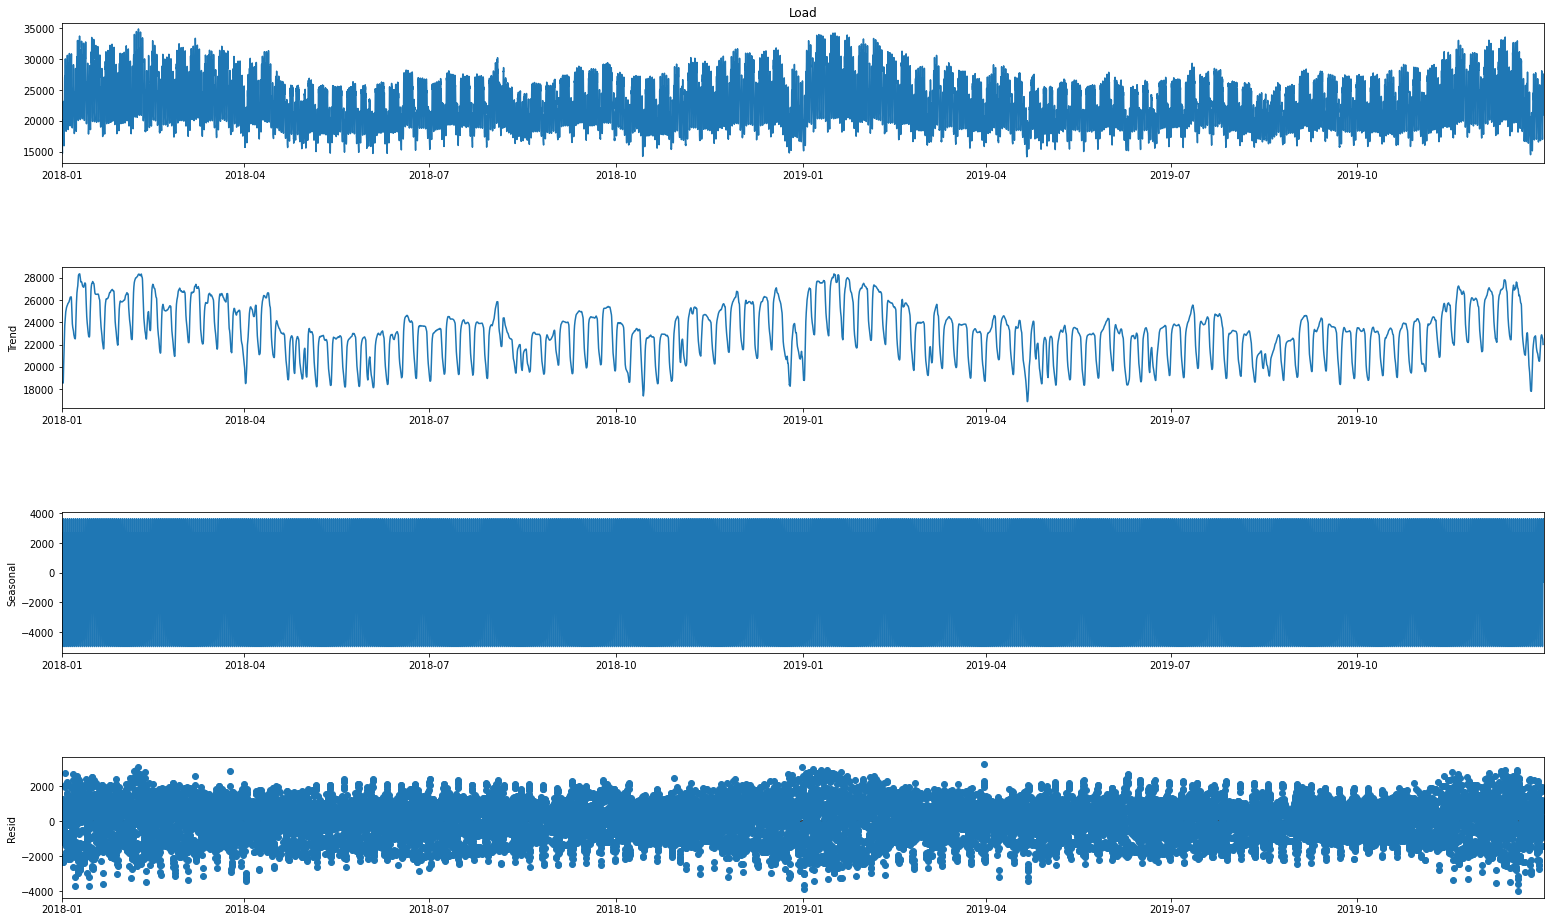

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts60['Load'],  model='additive', period=24)
f = result.plot()0
f.set_figheight(15)
f.set_figwidth(25)
plt.show()

This decomposition plots are not sufficient as we expect seasonal patterns of daily (24 timesteps), weekly (7x24 timesteps) and yearly (365x24 timesteps) periods. The rest of the analysis will take place in the R notebook. R_rdn_time_series_analysis.ipynb

In [12]:
result.resid.head(100)

Date
2018-01-01 00:00:00            NaN
2018-01-01 01:00:00            NaN
2018-01-01 02:00:00            NaN
2018-01-01 03:00:00            NaN
2018-01-01 04:00:00            NaN
                          ...     
2018-01-04 23:00:00    -764.724024
2018-01-05 00:00:00   -1413.592777
2018-01-05 01:00:00   -1734.399274
2018-01-05 02:00:00   -1915.189095
2018-01-05 03:00:00   -2173.310266
Name: resid, Length: 100, dtype: float64

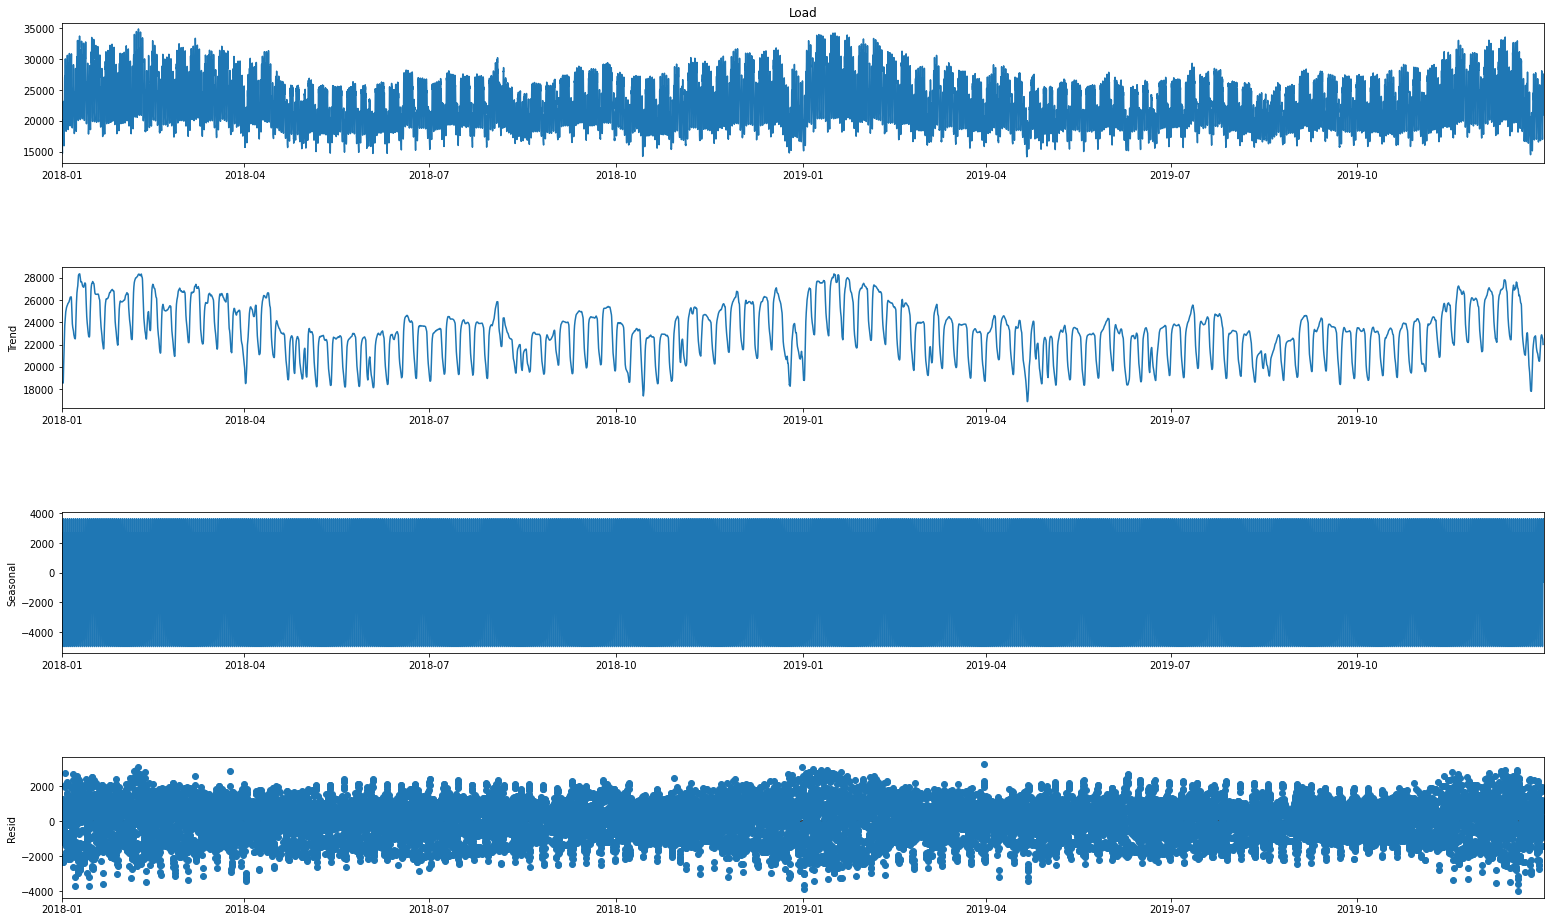

In [13]:
daily_deaseasonalized = ts60['Load'] - result.seasonal
result2 = seasonal_decompose(daily_deaseasonalized,  model='additive', period=24*7)
f = result.plot()
f.set_figheight(15)
f.set_figwidth(25)
plt.show()

In [15]:
result.seasonal.to_csv('../../RDN/Load Data (2018-2019)/artifacts/decomposition/rdn_daily_seasonality.csv')
result.observed.to_csv('../../RDN/Load Data (2018-2019)/artifacts/decomposition/rdn_observed.csv')
result2.seasonal.to_csv('../../RDN/Load Data (2018-2019)/artifacts/decomposition/rdn_weekly_seasonality.csv')
result2.trend.to_csv('../../RDN/Load Data (2018-2019)/artifacts/decomposition/rdn_trend.csv')
result2.resid.to_csv('../../RDN/Load Data (2018-2019)/artifacts/decomposition/rdn_resid.csv')